**<h1><center>Deep Learning Systems (ENGR-E 533) 
<br>Homework 5 , Fall 2021</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

**Organize Import statements**

In [1]:
#import some basic libraries

import numpy as np
import pandas as pd
import random
import math


import tensorflow as tf
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow import expand_dims
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.experimental.numpy.random import randint


import keras
from keras.backend import count_params
from keras.datasets import mnist
from keras.datasets.fashion_mnist import load_data
from keras.models import Sequential
from keras.layers import Conv2DTranspose
from keras.layers import Activation, Flatten, Dense, Dropout, Input, LeakyReLU
from keras.layers import Dense, BatchNormalization, concatenate, Lambda, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, InputLayer
from keras import backend as K

# libraries for plotting

import matplotlib.pyplot as plt
%matplotlib inline

# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# **Problem 4: Missing Value Imputation Using Conditional GAN**

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

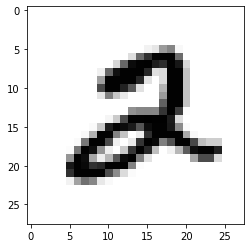

In [3]:
# plot raw pixel data
plt.imshow(X_train[5], cmap='gray')
plt.imshow(X_train[5], cmap='gray_r')

## Plot original data samples

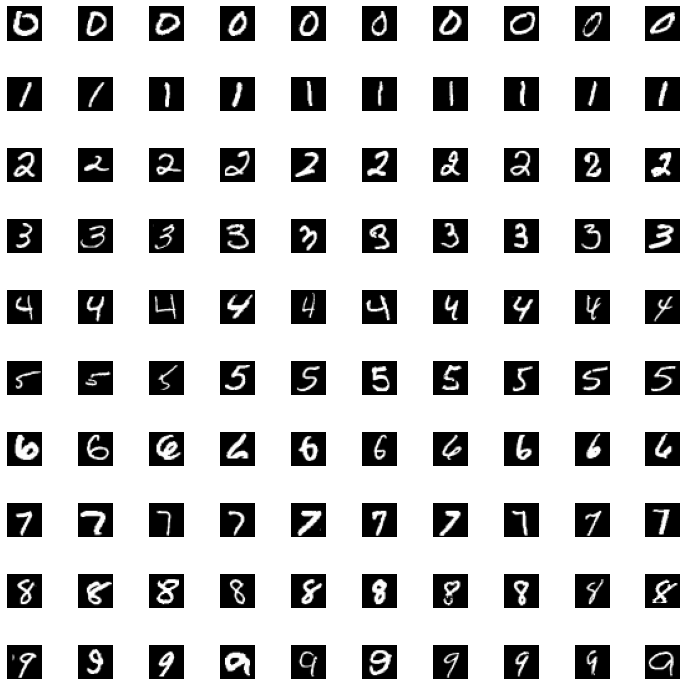

In [4]:
num_of_samples = []

cols = 10
num_of_classes = 10

fig, axs = plt.subplots(nrows=num_of_classes, ncols=cols,
                       figsize=(10, 10))
fig.tight_layout()
for i in range(cols):
  for j in range(num_of_classes):
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected -1)),
                                :, :],
                    cmap=plt.get_cmap('gray')
                    # cmap='gray_r'
                    )
    axs[j][i].axis("off")
    if i==2:
      #axs[j][i].set_title(str(j))
      num_of_samples.append(len(x_selected))

In [5]:
# print('X_patch.shape', X_patch.shape)
# print('y_train.shape', y_train.shape)

# # reshaping the inputs
# # normalizing the inputs (0, 1)
# X_patch_norm = X_patch.astype('float32') / 255

In [8]:
# in_idx = 4

# np.min(X_patch_norm[in_idx]) , np.max(X_patch_norm[in_idx])

In [9]:
# # Flatten the images.
# train_images = X_patch_norm.reshape((-1, 100))
# train_images.shape

In [10]:
# train_images.shape[1:]

**Random vectors of 100 dimensions drawn from the standard normal dis-
tribution**

In [28]:
mu, sigma = 0, 1 # mean and standard deviation
random_vecs = np.random.normal(mu, sigma, 100)
random_vecs.shape

(100,)

In [29]:
a = np.array([0,1,2,3,4,5])
b = np.array([9,9,9,9,9,9])
print(a.shape)
a = np.tile(a,(3,1))
b = np.tile(b,(3,1))
print(a) 
print(b) 
concat_mat = np.concatenate((a, b), axis =1)
print(concat_mat)

(6,)
[[0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]]
[[9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]]
[[0 1 2 3 4 5 9 9 9 9 9 9]
 [0 1 2 3 4 5 9 9 9 9 9 9]
 [0 1 2 3 4 5 9 9 9 9 9 9]]


In [13]:
# train_images.shape[0]

In [14]:
# random_mat = np.tile(random_vecs, (train_images.shape[0], 1))
# X_gen = np.concatenate((train_images, random_mat), axis =1) # along the axis axis , increase the columns

# X_gen.shape, y_train.shape

# Conditional GAN for MNIST

In [15]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  tf.keras.utils.plot_model(model,to_file='discriminator.png',show_shapes=True)
  return model

In [16]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  tf.keras.utils.plot_model(model,to_file='generator.png',show_shapes=True)
  return model

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

### **Discriminator input**

In [18]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

## **Generator input batch**

 Take their center 10 x 10 patches, and then fatten it. 
This is your 100-dimensional conditioning vector.

In [19]:
X_train_batches = np.split(X_train, 100)

In [20]:
len(X_train_batches)
X_train_batches[0].shape

(600, 28, 28)

In [27]:
X_train_batches_patch = []
for each in X_train_batches:
  #Take the center 10 x 10 patches for MNIST data
  X_train_batches_patch.append(each[:,9:19,9:19])

gen_ip_batch = tf.reshape(X_train_batches_patch, [-1,100,10,10])  
gen_ip_batch[0].shape

TensorShape([100, 10, 10])

In [22]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>40, 150/468, d1=0.666, d2=0.633 g=0.860
>40, 151/468, d1=0.667, d2=0.685 g=0.833
>40, 152/468, d1=0.653, d2=0.628 g=0.878
>40, 153/468, d1=0.683, d2=0.659 g=0.888
>40, 154/468, d1=0.685, d2=0.633 g=0.892
>40, 155/468, d1=0.633, d2=0.676 g=0.848
>40, 156/468, d1=0.643, d2=0.669 g=0.887
>40, 157/468, d1=0.711, d2=0.666 g=0.896
>40, 158/468, d1=0.639, d2=0.661 g=0.868
>40, 159/468, d1=0.668, d2=0.662 g=0.819
>40, 160/468, d1=0.663, d2=0.694 g=0.793
>40, 161/468, d1=0.677, d2=0.677 g=0.837
>40, 162/468, d1=0.674, d2=0.638 g=0.929
>40, 163/468, d1=0.685, d2=0.593 g=0.880
>40, 164/468, d1=0.662, d2=0.676 g=0.881
>40, 165/468, d1=0.646, d2=0.627 g=0.853
>40, 166/468, d1=0.689, d2=0.667 g=0.858
>40, 167/468, d1=0.636, d2=0.687 g=0.859
>40, 168/468, d1=0.669, d2=0.721 g=0.873
>40, 169/468, d1=0.621, d2=0.638 g=0.837
>40, 170/468, d1=0.669, d2=0.692 g=0.872
>40, 171/468, d1=0.648, d2=0.625 g=0.887
>40, 172/468, d1=0.653, d2=0.658 g=0.881
>40, 1

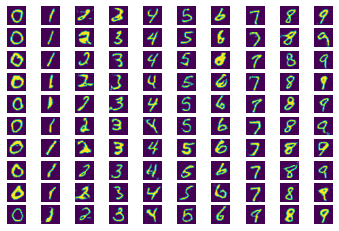

In [26]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		# pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
		pyplot.imshow(examples[i, :, :, 0])
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)